In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import uniform
#from BFM.MCMC_MGP import Gibbs_sampling
#from BFM.MCMC_CSP import Gibbs_sampling
from BFM.MCMC_LH import Gibbs_sampling
from BFM.VI import NGVI
from BFM.utils import FDR_FNR_mcmc, FDR_FNR_VI, FDR_FNR_COV, ESS

/opt/miniconda3/lib/python3.12/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [2]:
device1 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
P = 1000
K = 5
N = 100

In [4]:
B_0 = np.random.binomial(1, 1 / 3,(P,K)) * np.random.rand(P,K)
cov_0 = B_0 @ B_0.T + np.diag(uniform.rvs(loc = 0.1, scale = 0.9, size = P))
X = np.random.multivariate_normal(np.zeros(P), cov_0, N)

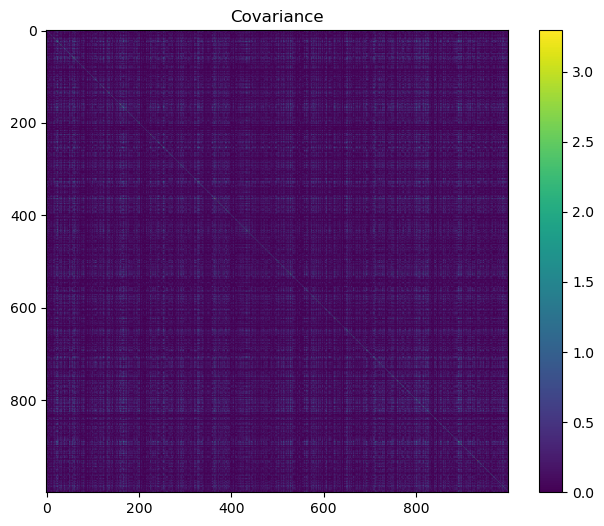

In [5]:
plt.figure(figsize=(8, 6))
plt.imshow(cov_0)
plt.colorbar()
plt.title("Covariance")
plt.show()

In [6]:
B_sample, sigma2_sample = Gibbs_sampling(X, device = device1)


100%|██████████| 9999/9999 [08:10<00:00, 20.39it/s]


In [7]:
mu, Cov, np_sigma, v = NGVI(X, device = device1)

100%|██████████| 10/10 [00:23<00:00,  2.32s/it]


In [8]:
cov_VI = mu @ mu.T + (v / (v - 2)) * torch.diag(torch.vmap(torch.trace)(Cov)) + torch.diag(np_sigma / (0.5 * N))

In [9]:
cov_mcmc = torch.einsum('bij,bjk->ik',B_sample, B_sample.transpose(1,2)) / B_sample.size(0) + torch.diag(sigma2_sample.mean(0))

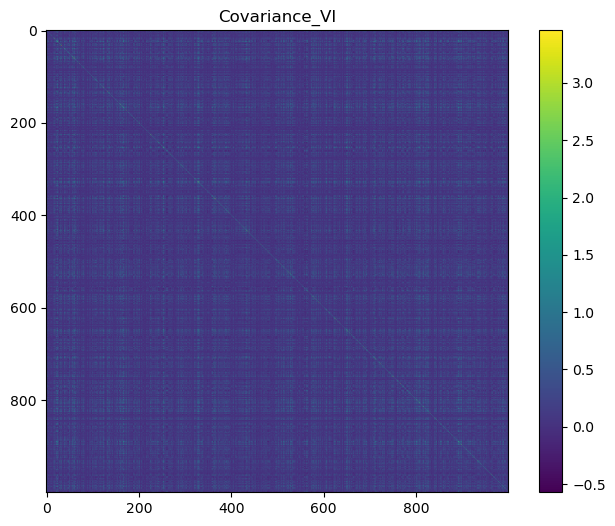

In [10]:
plt.figure(figsize=(8, 6))
plt.imshow(cov_VI)
plt.colorbar()
plt.title("Covariance_VI")
plt.show()

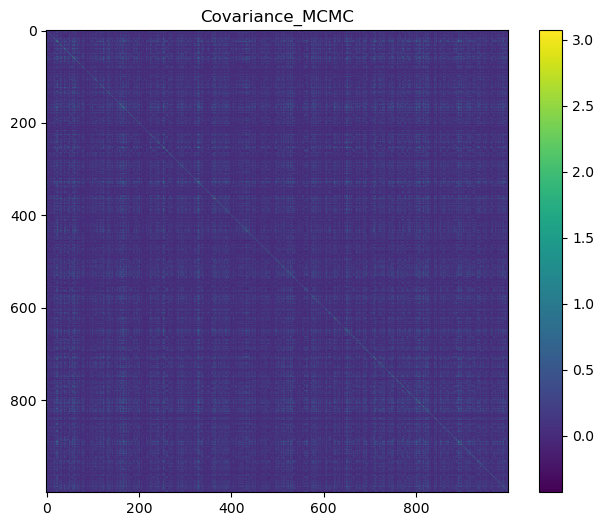

In [11]:
plt.figure(figsize=(8, 6))
plt.imshow(cov_mcmc)
plt.colorbar()
plt.title("Covariance_MCMC")
plt.show()

[]

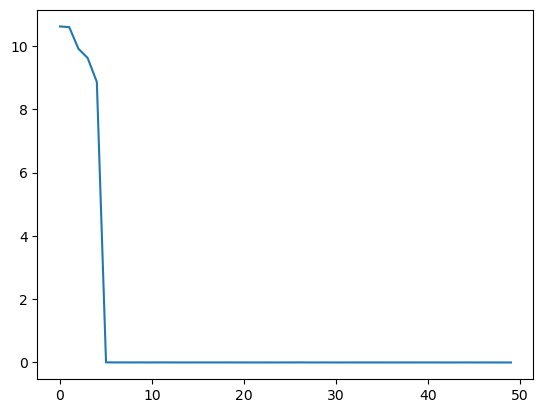

In [12]:
B_mean = B_sample.mean(0)
plt.plot(torch.norm(B_mean, dim = 0).numpy())
plt.plot()

[]

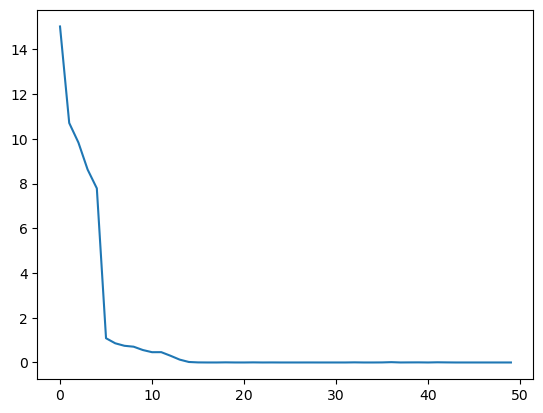

In [13]:
plt.plot(torch.norm(mu, dim = 0).numpy())
plt.plot()

In [14]:
_, _, num_K_mcmc = FDR_FNR_mcmc(B_sample, B_0)

In [15]:
_, _, num_K_VI = FDR_FNR_VI(mu, Cov, v, B_0)

In [16]:
(torch.from_numpy(cov_0) - cov_VI).square().sum().sqrt()

tensor(94.1585, dtype=torch.float64)

In [17]:
(torch.from_numpy(cov_0) - cov_mcmc).square().sum().sqrt()

tensor(89.4027, dtype=torch.float64)

In [18]:
FDR_COV_mcmc, FNR_COV_mcmc= FDR_FNR_COV(cov_0, cov_mcmc.numpy())

In [19]:
FDR_COV_VI, FNR_COV_VI= FDR_FNR_COV(cov_0, cov_VI.numpy())

In [20]:
print(FDR_COV_mcmc)
print(FNR_COV_mcmc)

0.5501245511241718
0.000646547880214743


In [21]:
print(FDR_COV_VI)
print(FNR_COV_VI)

0.5490280177361089
0.0013778158274921077


In [22]:
ess_B = ESS(B_sample.numpy())

In [ ]:
ess_sigma2 = ESS(sigma2_sample.numpy())

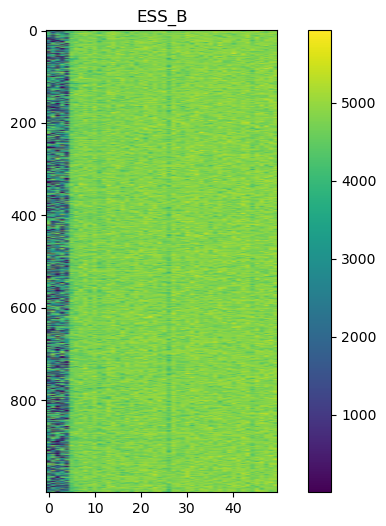

In [23]:
plt.figure(figsize=(8, 6))
plt.imshow(ess_B, aspect = 0.1)
plt.colorbar()
plt.title("ESS_B")
plt.show()